# Sampyo

1. classification model
2. 7class
3. 2.5% + 5%

## Import module

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import random

Using TensorFlow backend.
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cai/anaconda3/envs/MRCNN/l

## train data / test data

In [2]:
dataset_name = "./crop_dataset_water"

x_train = []
y_train = []
x_test = []
y_test = []

folder_list = os.listdir(dataset_name)
folder_list.sort()

In [3]:
folder_list

['FM_2.4_2.5%',
 'FM_2.4_5%',
 'FM_2.6_2.5%',
 'FM_2.6_5%',
 'FM_2.8_2.5%',
 'FM_2.8_5%',
 'FM_3.0_2.5%',
 'FM_3.0_5%',
 'FM_3.2_2.5%',
 'FM_3.2_5%',
 'FM_3.4_2.5%',
 'FM_3.4_5%',
 'FM_3.61_2.5%',
 'FM_3.61_5%']

In [4]:
for one_folder in folder_list:
    splited_one_folder =  one_folder.split("_")
    eveloped_one_folder = splited_one_folder[0]+"_"+splited_one_folder[1]
    # eveloped_one_folder : FM_classnum
    print(one_folder)
    
    join_folder_path = os.path.join(dataset_name, one_folder)
    # dataset folder path
    data_list = os.listdir(join_folder_path)
    # data list in folder
    
    ## train / test = 8:2
    test_list = random.sample(data_list, int(len(data_list) * 0.2))

    for one_data in data_list:
        
        join_data_path = os.path.join(join_folder_path, one_data)
        # each data path
        
        ### imread / resize / normalize
        img = cv2.imread(join_data_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (512,512))
        img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        img = np.reshape(img, (512,512,1)) # one channel

        # train
        if not one_data in test_list:
            # if data is not in test_list which is sampled before, add data in x_train, and class in y_train
            x_train.append(img)
            y_train.append(eveloped_one_folder)
            
        elif one_data in test_list:
            x_test.append(img)
            y_test.append(eveloped_one_folder)

            
tmp = [[x,y] for x,y in zip(x_train, y_train)]
random.shuffle(tmp)

x_train = [n[0] for n in tmp]
y_train = [n[1] for n in tmp]
            
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)  
y_test = np.array(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

FM_2.4_2.5%
FM_2.4_5%
FM_2.6_2.5%
FM_2.6_5%
FM_2.8_2.5%
FM_2.8_5%
FM_3.0_2.5%
FM_3.0_5%
FM_3.2_2.5%
FM_3.2_5%
FM_3.4_2.5%
FM_3.4_5%
FM_3.61_2.5%
FM_3.61_5%
(9348, 512, 512, 1)
(9348,)
(2333, 512, 512, 1)
(2333,)


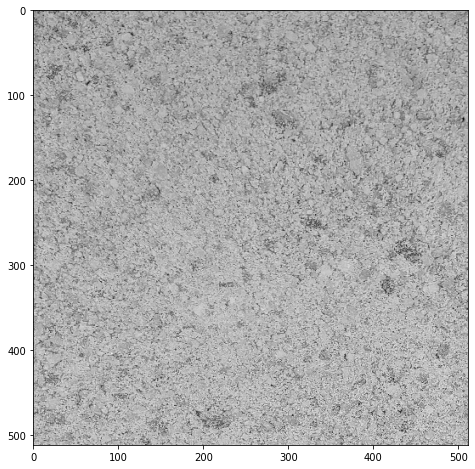

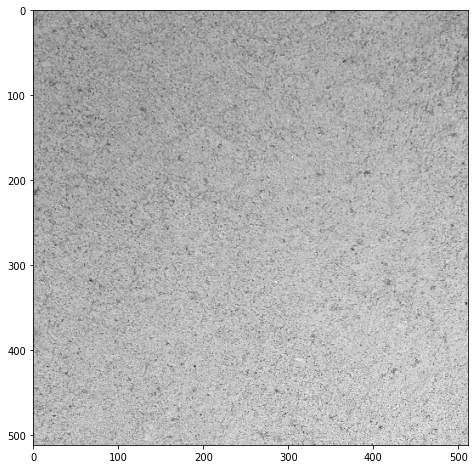

In [5]:
plt.figure(figsize=(8,8))
plt.imshow(x_train[1].reshape(512,512), cmap="gray")

plt.figure(figsize=(8,8))
plt.imshow(x_test[0].reshape(512,512), cmap="gray")

## Y data onehot encoding

* ex1) 2 -> [1,0,0,0,0,0]
* ex2) 7 -> [0,0,0,0,0,1]

In [6]:
from sklearn.preprocessing import OneHotEncoder

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

enc = OneHotEncoder()
enc.fit(y_train)

y_train_onehot = enc.transform(y_train).toarray()
y_test_onehot = enc.transform(y_test).toarray()

print(y_test_onehot)
print(y_test)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[['FM_2.4']
 ['FM_2.4']
 ['FM_2.4']
 ...
 ['FM_3.61']
 ['FM_3.61']
 ['FM_3.61']]


## Import keras module

In [7]:
import keras

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization

from keras.utils import multi_gpu_model

from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

## Deep Learning Model

In [8]:
inputs = Input((512, 512, 1))

# Layer 1
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(inputs)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 2
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 3
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 4
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 5
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 6
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 7
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

x = Flatten()(x)
x = Dense(128, activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Dense(64, activation = 'relu',kernel_initializer="glorot_normal")(x)
outputs = Dense(7, activation = 'softmax',kernel_initializer="glorot_normal")(x)

model = Model(inputs=[inputs], outputs=[outputs])

#model.summary()
# keras.utils.vis_utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# from IPython.display import Image
# Image("model_plot.png")

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 128)     1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 128)     147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 128)     0         
__________

In [10]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train_onehot,y_val_onehot = train_test_split(x_train,y_train_onehot, test_size = 0.1, shuffle = True, random_state = 42)

In [11]:
#early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', verbose = 0, patience = 20, mode = 'auto')

#checkpoint
checkpoint_path = './minyoung_checkpoint/cp--alldata--{epoch:04d}.ckpt'
cp_dir = os.path.dirname(checkpoint_path)
checkpoint_50epoch = keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True, verbose = 1, period = 50)

## Learning

Instructions for updating:
Use tf.cast instead.
Train on 8413 samples, validate on 935 samples
Epoch 1/500
8413/8413 [==============================] - 215s 26ms/step - loss: 1.9459 - acc: 0.1527 - val_loss: 1.9458 - val_acc: 0.1487
Epoch 2/500
8413/8413 [==============================] - 204s 24ms/step - loss: 1.9449 - acc: 0.1542 - val_loss: 1.9434 - val_acc: 0.1487
Epoch 3/500
8413/8413 [==============================] - 205s 24ms/step - loss: 1.9429 - acc: 0.1508 - val_loss: 1.9428 - val_acc: 0.1529
Epoch 4/500
8413/8413 [==============================] - 205s 24ms/step - loss: 1.9423 - acc: 0.1543 - val_loss: 1.9428 - val_acc: 0.1529
Epoch 5/500
8413/8413 [==============================] - 205s 24ms/step - loss: 1.9421 - acc: 0.1543 - val_loss: 1.9428 - val_acc: 0.1529
Epoch 6/500
8413/8413 [==============================] - 205s 24ms/step - loss: 1.9420 - acc: 0.1533 - val_loss: 1.9428 - val_acc: 0.1529
Epoch 7/500
8413/8413 [==============================] - 205s 24ms/step - los

8413/8413 [==============================] - 205s 24ms/step - loss: 1.3701 - acc: 0.4859 - val_loss: 1.4609 - val_acc: 0.4481
Epoch 57/500
8413/8413 [==============================] - 205s 24ms/step - loss: 1.3540 - acc: 0.4870 - val_loss: 1.5026 - val_acc: 0.4417
Epoch 58/500
8413/8413 [==============================] - 205s 24ms/step - loss: 1.3440 - acc: 0.4925 - val_loss: 1.4488 - val_acc: 0.4695
Epoch 59/500
8413/8413 [==============================] - 205s 24ms/step - loss: 1.3311 - acc: 0.4998 - val_loss: 1.4095 - val_acc: 0.4791
Epoch 60/500
8413/8413 [==============================] - 205s 24ms/step - loss: 1.3235 - acc: 0.5041 - val_loss: 1.4144 - val_acc: 0.4834
Epoch 61/500
8413/8413 [==============================] - 205s 24ms/step - loss: 1.3144 - acc: 0.5062 - val_loss: 1.4766 - val_acc: 0.4567
Epoch 62/500
8413/8413 [==============================] - 205s 24ms/step - loss: 1.3034 - acc: 0.5097 - val_loss: 1.3876 - val_acc: 0.4813
Epoch 63/500
8413/8413 [================

Epoch 114/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.7846 - acc: 0.7036 - val_loss: 1.0145 - val_acc: 0.6246
Epoch 115/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.7750 - acc: 0.7097 - val_loss: 0.9120 - val_acc: 0.6503
Epoch 116/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.7725 - acc: 0.7095 - val_loss: 0.9791 - val_acc: 0.6353
Epoch 117/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.7662 - acc: 0.7064 - val_loss: 1.0140 - val_acc: 0.6182
Epoch 118/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.7552 - acc: 0.7132 - val_loss: 0.9271 - val_acc: 0.6449
Epoch 119/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.7508 - acc: 0.7152 - val_loss: 0.9388 - val_acc: 0.6417
Epoch 120/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.7511 - acc: 0.7150 - val_loss: 0.9923 - val_acc: 0.6289
Epoch 121/500
8413/8

8413/8413 [==============================] - 205s 24ms/step - loss: 0.5316 - acc: 0.8026 - val_loss: 0.8167 - val_acc: 0.7048
Epoch 172/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.5327 - acc: 0.8019 - val_loss: 0.7889 - val_acc: 0.7016
Epoch 173/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.5239 - acc: 0.8039 - val_loss: 0.8806 - val_acc: 0.6824
Epoch 174/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.5185 - acc: 0.8082 - val_loss: 0.9059 - val_acc: 0.6834
Epoch 175/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.5125 - acc: 0.8063 - val_loss: 0.7458 - val_acc: 0.7187
Epoch 176/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.5135 - acc: 0.8121 - val_loss: 0.8601 - val_acc: 0.6856
Epoch 177/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.5253 - acc: 0.8005 - val_loss: 0.7344 - val_acc: 0.7273
Epoch 178/500
8413/8413 [=========

8413/8413 [==============================] - 205s 24ms/step - loss: 0.3754 - acc: 0.8660 - val_loss: 0.7644 - val_acc: 0.7390
Epoch 229/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.3751 - acc: 0.8634 - val_loss: 0.7687 - val_acc: 0.7316
Epoch 230/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.3666 - acc: 0.8632 - val_loss: 0.7420 - val_acc: 0.7508
Epoch 231/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.3614 - acc: 0.8708 - val_loss: 0.7208 - val_acc: 0.7497
Epoch 232/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.3697 - acc: 0.8659 - val_loss: 0.7008 - val_acc: 0.7412
Epoch 233/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.3594 - acc: 0.8698 - val_loss: 0.8804 - val_acc: 0.7102
Epoch 234/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.3630 - acc: 0.8676 - val_loss: 0.7326 - val_acc: 0.7455
Epoch 235/500
8413/8413 [=========

8413/8413 [==============================] - 205s 24ms/step - loss: 0.2650 - acc: 0.9031 - val_loss: 0.7805 - val_acc: 0.7583
Epoch 286/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.2562 - acc: 0.9119 - val_loss: 0.7606 - val_acc: 0.7551
Epoch 287/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.2520 - acc: 0.9111 - val_loss: 0.7926 - val_acc: 0.7508
Epoch 288/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.2509 - acc: 0.9106 - val_loss: 0.8530 - val_acc: 0.7508
Epoch 289/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.2428 - acc: 0.9124 - val_loss: 0.9190 - val_acc: 0.7316
Epoch 290/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.2468 - acc: 0.9125 - val_loss: 0.7968 - val_acc: 0.7540
Epoch 291/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.2393 - acc: 0.9125 - val_loss: 0.7881 - val_acc: 0.7615
Epoch 292/500
8413/8413 [=========

8413/8413 [==============================] - 206s 24ms/step - loss: 0.1734 - acc: 0.9420 - val_loss: 0.8289 - val_acc: 0.7711
Epoch 343/500
8413/8413 [==============================] - 206s 24ms/step - loss: 0.1700 - acc: 0.9402 - val_loss: 0.9890 - val_acc: 0.7487
Epoch 344/500
8413/8413 [==============================] - 206s 24ms/step - loss: 0.1590 - acc: 0.9472 - val_loss: 1.0044 - val_acc: 0.7465
Epoch 345/500
8413/8413 [==============================] - 206s 24ms/step - loss: 0.1661 - acc: 0.9445 - val_loss: 0.8251 - val_acc: 0.7701
Epoch 346/500
8413/8413 [==============================] - 206s 24ms/step - loss: 0.1673 - acc: 0.9425 - val_loss: 0.8045 - val_acc: 0.7861
Epoch 347/500
8413/8413 [==============================] - 206s 24ms/step - loss: 0.1639 - acc: 0.9450 - val_loss: 0.8667 - val_acc: 0.7668
Epoch 348/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.1620 - acc: 0.9473 - val_loss: 0.9199 - val_acc: 0.7540
Epoch 349/500
8413/8413 [=========

8413/8413 [==============================] - 206s 24ms/step - loss: 0.1063 - acc: 0.9636 - val_loss: 0.9443 - val_acc: 0.7775
Epoch 400/500
8412/8413 [============================>.] - ETA: 0s - loss: 0.1198 - acc: 0.9605
Epoch 00400: saving model to ./minyoung_checkpoint/cp--alldata--0400.ckpt
8413/8413 [==============================] - 206s 25ms/step - loss: 0.1198 - acc: 0.9605 - val_loss: 0.9512 - val_acc: 0.7786
Epoch 401/500
8413/8413 [==============================] - 206s 24ms/step - loss: 0.1000 - acc: 0.9658 - val_loss: 1.0561 - val_acc: 0.7615
Epoch 402/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.1153 - acc: 0.9596 - val_loss: 0.9704 - val_acc: 0.7754
Epoch 403/500
8413/8413 [==============================] - 206s 24ms/step - loss: 0.1055 - acc: 0.9642 - val_loss: 1.1069 - val_acc: 0.7529
Epoch 404/500
8413/8413 [==============================] - 206s 24ms/step - loss: 0.0940 - acc: 0.9676 - val_loss: 1.0647 - val_acc: 0.7754
Epoch 405/500
8413

8413/8413 [==============================] - 206s 24ms/step - loss: 0.0718 - acc: 0.9797 - val_loss: 1.3946 - val_acc: 0.7572
Epoch 456/500
8413/8413 [==============================] - 206s 24ms/step - loss: 0.0782 - acc: 0.9765 - val_loss: 1.2438 - val_acc: 0.7658
Epoch 457/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.0710 - acc: 0.9800 - val_loss: 1.0128 - val_acc: 0.7765
Epoch 458/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.0759 - acc: 0.9810 - val_loss: 1.0141 - val_acc: 0.7829
Epoch 459/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.0730 - acc: 0.9781 - val_loss: 1.1334 - val_acc: 0.7829
Epoch 460/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.0771 - acc: 0.9766 - val_loss: 1.1211 - val_acc: 0.7701
Epoch 461/500
8413/8413 [==============================] - 205s 24ms/step - loss: 0.0588 - acc: 0.9826 - val_loss: 1.1972 - val_acc: 0.7626
Epoch 462/500
8413/8413 [=========

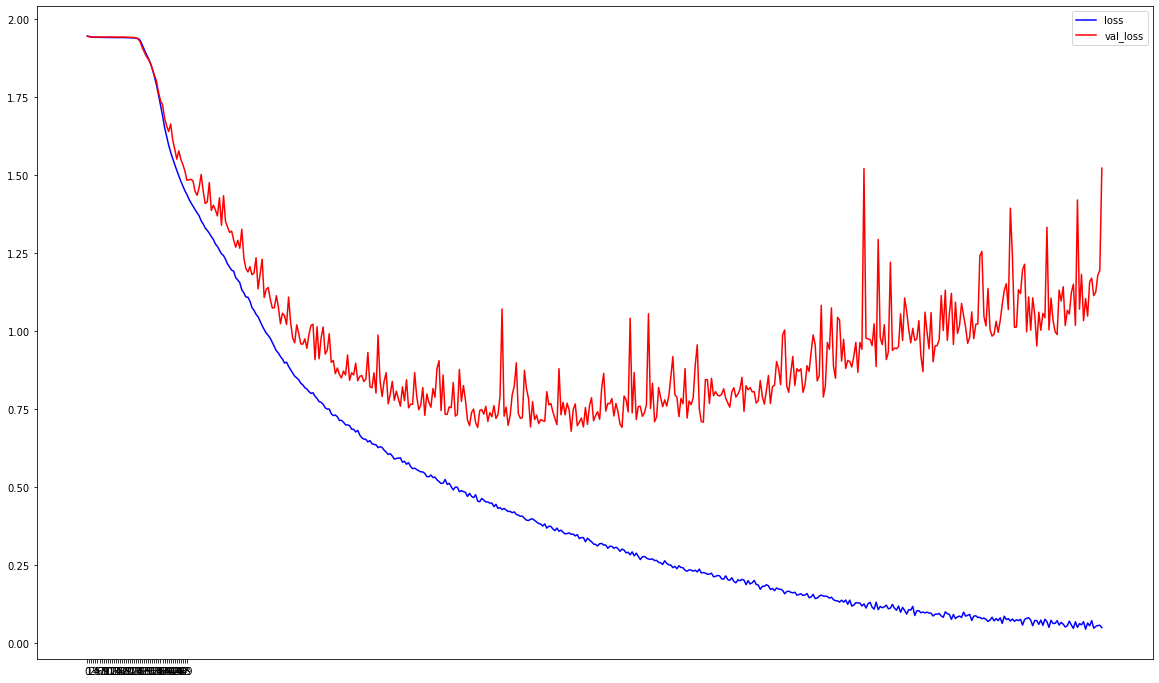

In [13]:
parallel_model = multi_gpu_model(model,gpus=2)

# callback
# early_stopping = EarlyStopping(monitor='val_loss',patience = 30)

# optimizer
adam = keras.optimizers.Adam(lr=0.000001)
parallel_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# fit model
hist = parallel_model.fit(x_train, y_train_onehot,\
                          epochs=500, batch_size=4,\
                          validation_data=(x_val, y_val_onehot),\
                         callbacks = [checkpoint_50epoch])

# plot loss & val_loss
plt.figure(figsize=(20,12))
plt.plot(hist.history['loss'],'b',label='loss')
plt.plot(hist.history['val_loss'],'r',label='val_loss')
plt.xticks(np.arange(0,50,1))
plt.legend(loc="upper right");

## Predict

In [14]:
pred_y = parallel_model.predict(x_test)


In [15]:
y_test_onehot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [16]:
pred_y = np.argmax(pred_y,axis=1 )
real_y = np.argmax(y_test_onehot,axis=1)

print(pred_y)
print(real_y)

[0 0 1 ... 6 6 6]
[0 0 0 ... 6 6 6]


In [17]:
corr_num1 = 0
corr_num2 = 0
for i in range(real_y.shape[0]):
    if pred_y[i] == real_y[i]:
        corr_num1 += 1
        
    if abs(int(pred_y[i]) - int(real_y[i])) <= 1:
        corr_num2 += 1
        
print(corr_num1 / real_y.shape[0] * 100, "%")
print(corr_num2 / real_y.shape[0] * 100, "%")

72.91041577368196 %
91.34162023146163 %


## Confusion Matrix

In [18]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(pred_y, real_y)

['2.4', '2.6', '2.8', '3.0', '3.2', '3.4', '3.61']


<AxesSubplot:>

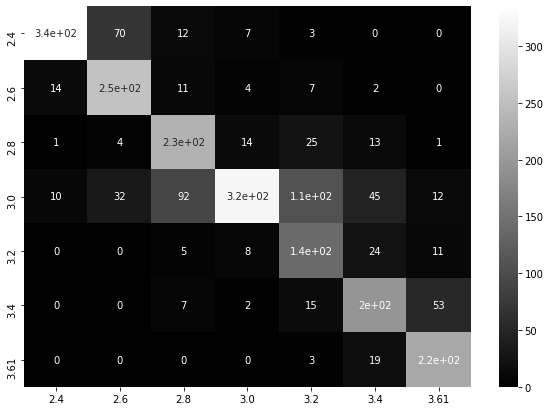

In [19]:
import seaborn as sn
import pandas as pd


cm_list = []
for one_folder in folder_list:
    splited_folder = one_folder.split("_")
    cm_list.append(splited_folder[1])
    cm_list = set(cm_list)
    cm_list = list(cm_list)
    cm_list.sort()
print(cm_list)
df_cm = pd.DataFrame(conf_mat, index = [i for i in cm_list],
                  columns = [i for i in cm_list])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="gray")

<AxesSubplot:>

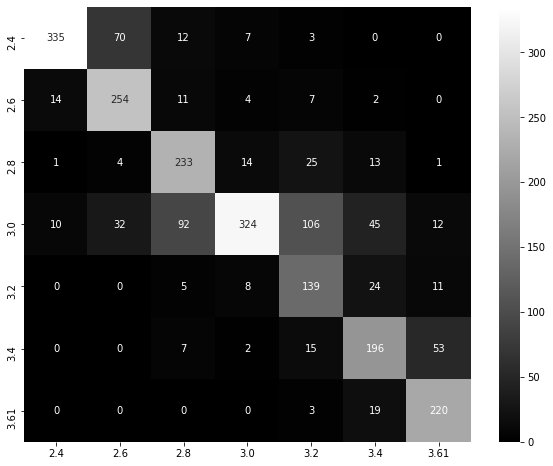

In [20]:
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True, cmap="gray", fmt="g")

In [21]:
model.save("model_alldata_epoch5000_210129")